In [9]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_q1 import CustomTimeSeriesDataset, weighted_sampler_dataloader
from torch.utils.data import DataLoader
import torch
from model_q1 import ResCNN
from copy import deepcopy
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

In [2]:
model = ResCNN()
nettype = 'CNN'
model_parameters_path = "./Model_Parameters/ResCNN_mitbih_best_parameters.pth"
model.load_state_dict(torch.load(model_parameters_path))
# print(model)

encoder_q1 = deepcopy(model)
del encoder_q1.fc1
del encoder_q1.fc2

# Freeze all parameters
for i, param in enumerate(encoder_q1.parameters()):
    param.requires_grad = False

# Modify forward function
def new_forward(self, x):
    out=self.bn1(self.conv1(x))
    out=self.resblock3(self.resblock2(self.resblock1(out)))
    out=self.maxpoolf(out)
    out=out.view(out.size(0), -1)
    return out

encoder_q1.forward = new_forward.__get__(encoder_q1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
encoder_q1.to(device)

cpu


ResCNN(
  (conv1): Conv1d(1, 24, kernel_size=(5,), stride=(3,), padding=(1,))
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock2): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock3): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3

In [3]:
# Load MIT-BIH
mitbih_train_dataset = CustomTimeSeriesDataset('mitbih_train.csv', NetType=nettype)
mitbih_train_loader = DataLoader(mitbih_train_dataset, batch_size=len(mitbih_train_dataset), shuffle=False)

# Load PTB
ptb_train_dataset = CustomTimeSeriesDataset('ptbdb_train.csv', NetType=nettype)
ptb_train_loader = DataLoader(ptb_train_dataset, batch_size=len(ptb_train_dataset), shuffle=False)

In [4]:
print('mitbih_train: ', len(mitbih_train_dataset))
print('ptb_train: ', len(ptb_train_dataset))

mitbih_train:  87553
ptb_train:  11640


In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter

def subsample_class_balanced(dataset, size):
    labels = dataset.labels.numpy()
    unique_classes = np.unique(labels)
    num_classes = len(unique_classes)
    samples_per_class = size // num_classes
    subsample_indices = []
    for label_value in unique_classes:
        indices_with_label = [idx for idx, lbl in enumerate(labels) if lbl == label_value]
        indx = indices_with_label[:samples_per_class]
        subsample_indices.append(indx)
    subsample_indices = np.concatenate(subsample_indices, axis=0)
    return subsample_indices


mitbih_train_sub_indices = subsample_class_balanced(mitbih_train_dataset, 500)
mitbih_train_sub = torch.utils.data.Subset(mitbih_train_dataset, mitbih_train_sub_indices)
ptb_train_dataset_indices = subsample_class_balanced(ptb_train_dataset, 500)
ptb_train_sub = torch.utils.data.Subset(ptb_train_dataset, ptb_train_dataset_indices)
print('mitbih_train_sub: ', len(mitbih_train_sub))
print('ptb_train_sub: ', len(ptb_train_sub))

mitbih_train_sub:  500
ptb_train_sub:  500


In [6]:
mitbih_train_sub_loader = DataLoader(mitbih_train_sub, batch_size=len(mitbih_train_sub), shuffle=False)
ptb_train_sub_loader = DataLoader(ptb_train_sub, batch_size=len(ptb_train_sub), shuffle=False)

In [7]:
mitbih_features_sub = []
mitbih_labels_sub = []
ptbdb_features_sub = []
ptbdb_labels_sub = []

encoder_q1.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(mitbih_train_sub_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        mitbih_features_sub.append(features.numpy())
        mitbih_labels_sub.append(labels)

    for i, (inputs, labels) in enumerate(ptb_train_sub_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        ptbdb_features_sub.append(features.numpy())
        ptbdb_labels_sub.append(labels)
        
# Concatenate features and labels lists
mitbih_features_sub = np.concatenate(mitbih_features_sub, axis=0)
mitbih_labels_sub = np.concatenate(mitbih_labels_sub, axis=0)
ptbdb_features_sub = np.concatenate(ptbdb_features_sub, axis=0)
ptbdb_labels_sub = np.concatenate(ptbdb_labels_sub, axis=0)

print("mitbih_features_sub shape:", mitbih_features_sub.shape)
print("mitbih_labels_sub shape:", mitbih_labels_sub.shape)
print("ptbdb_features_sub shape:", ptbdb_features_sub.shape)
print("ptbdb_labels_sub shape:", ptbdb_labels_sub.shape)

mitbih_features_sub shape: (500, 744)
mitbih_labels_sub shape: (500, 1)
ptbdb_features_sub shape: (500, 744)
ptbdb_labels_sub shape: (500, 1)


In [8]:
## PCA to reduce dimensions to 50
mitbih_pca = PCA(n_components=50).fit_transform(mitbih_features_sub)
ptbdb_pca = PCA(n_components=50).fit_transform(ptbdb_features_sub)
print("mitbih_pca shape:", mitbih_pca.shape)
print("ptbdb_pca shape:", ptbdb_pca.shape)

mitbih_pca shape: (500, 50)
ptbdb_pca shape: (500, 50)


100%|██████████| 4/4 [00:23<00:00,  5.78s/it]


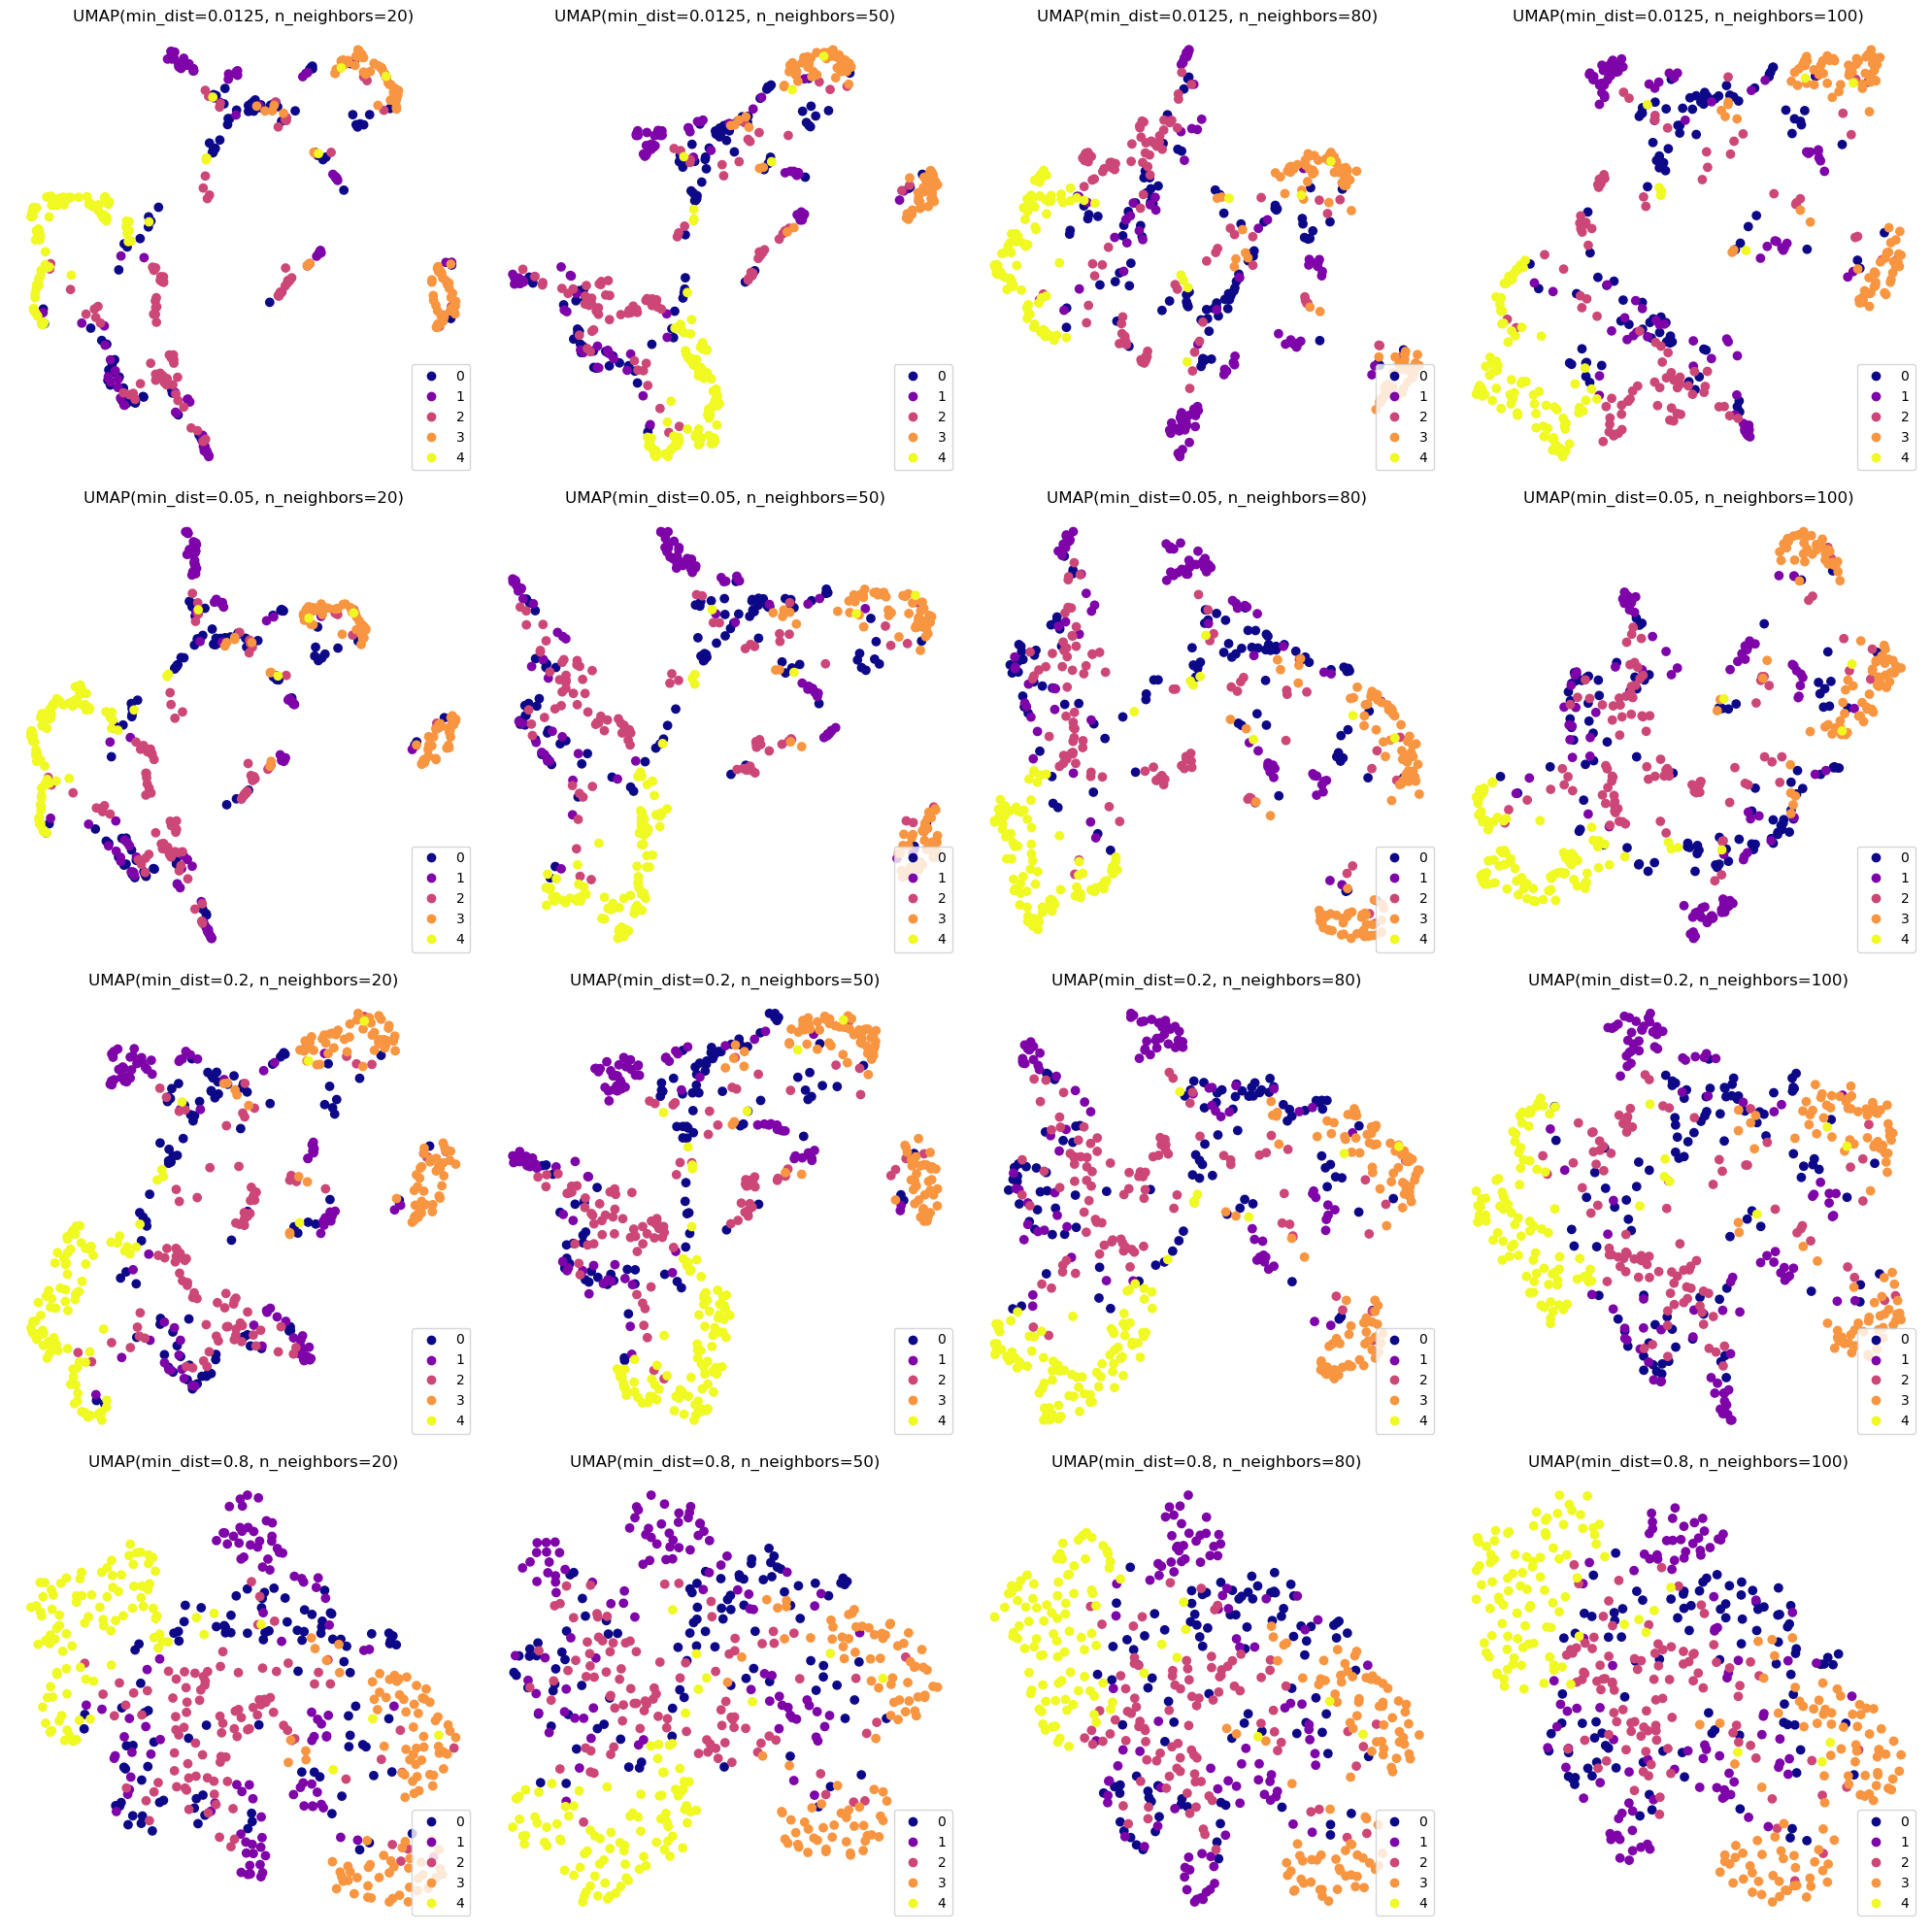

In [61]:
from tqdm import tqdm

min_dist_values = np.array([0.0125, 0.05, 0.2, 0.8])
n_neighbors_values = np.array([20, 50, 80, 100])

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, min_dist in enumerate(min_dist_values):
    for j, n_neighbors in enumerate(tqdm(n_neighbors_values)):
        # Perform UMAP on the features with current min_dist and n_neighbors
        umap_model = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors)
        embeddings = umap_model.fit_transform(mitbih_pca)

        # Plot UMAP embeddings with labels
        ax = axes[i, j]
        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=mitbih_labels_sub, cmap=plt.cm.plasma)
        ax.set_title(f'UMAP(min_dist={min_dist}, n_neighbors={n_neighbors})')
        ax.set_axis_off()
        ax.legend(*scatter.legend_elements(),loc='lower right')

plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


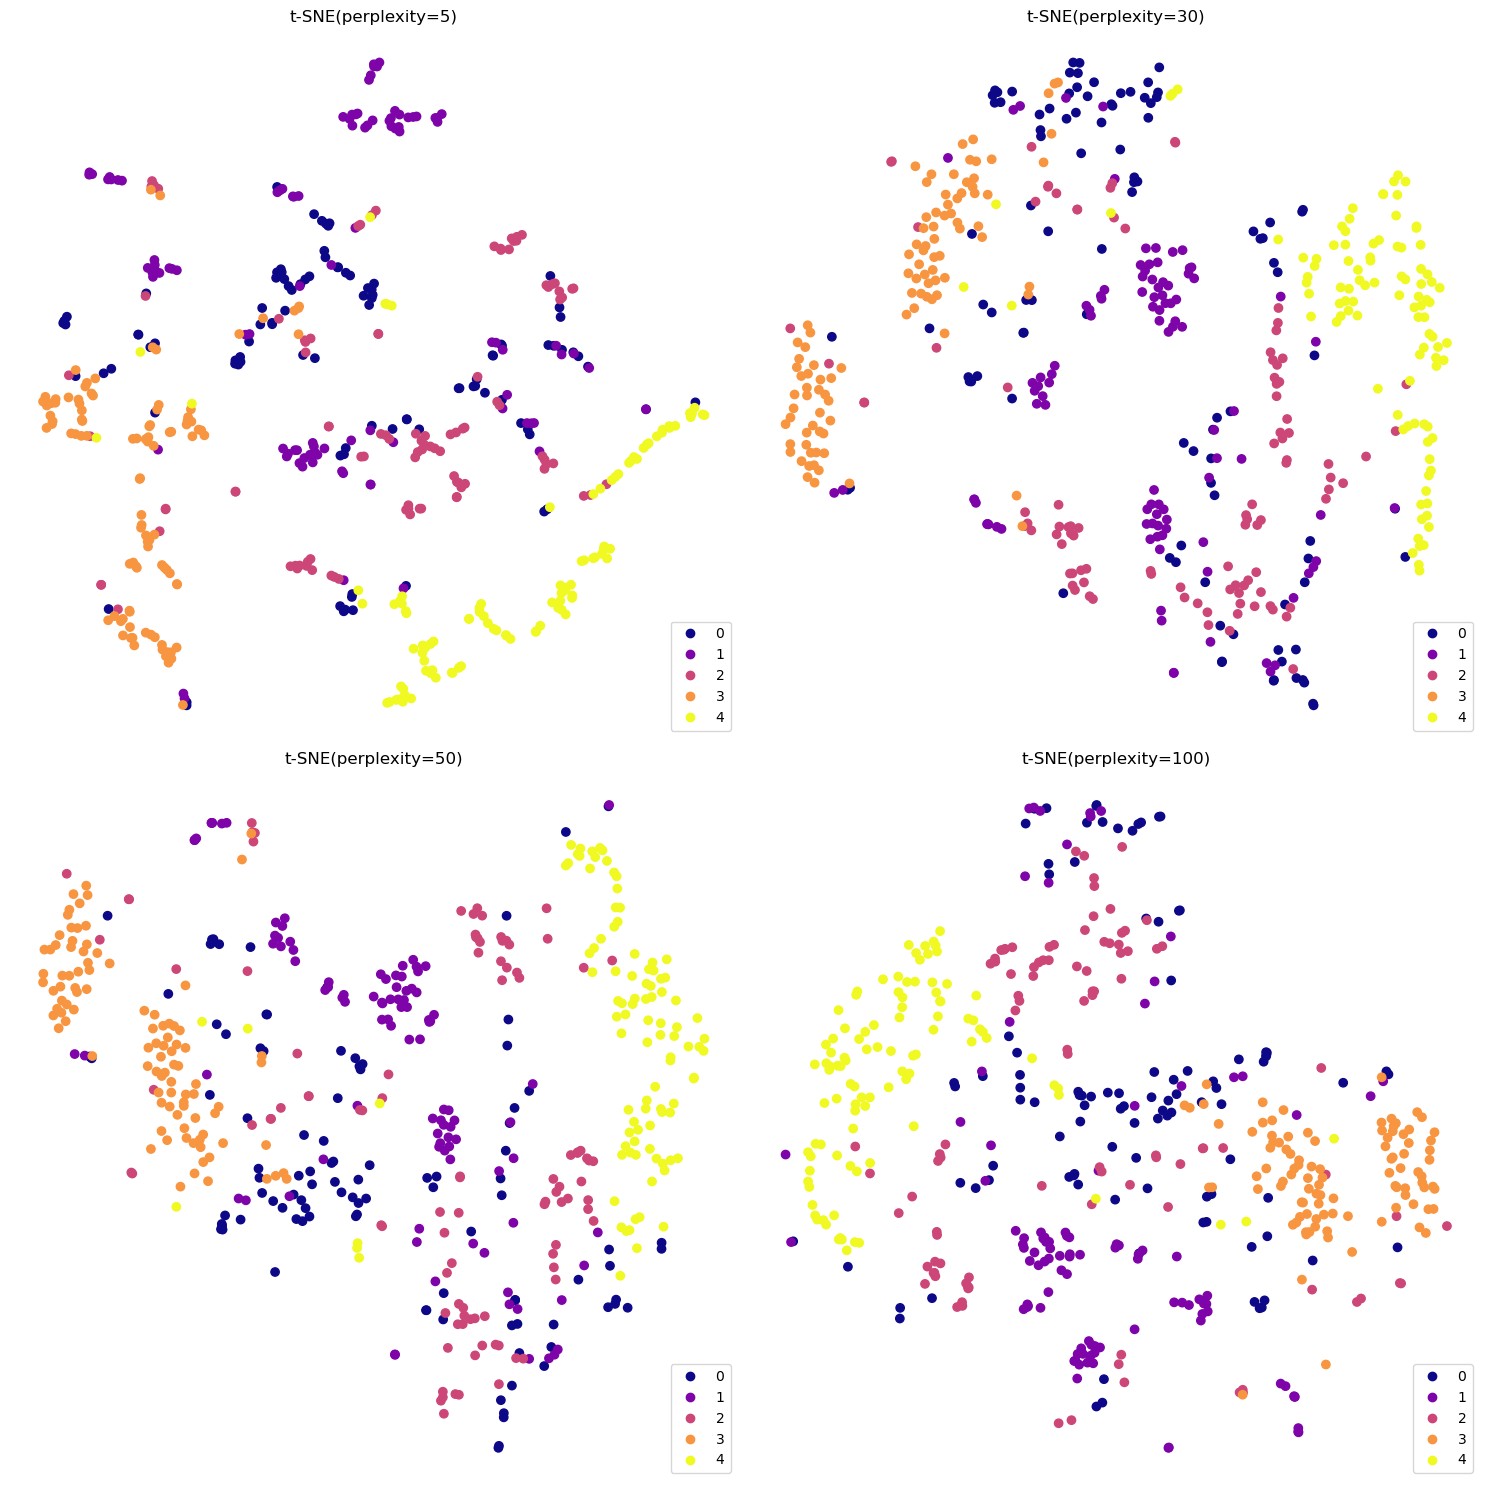

In [12]:
from tqdm import tqdm

perplexity_values = np.array([5, 30, 50, 100])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, perplexity in enumerate(tqdm(perplexity_values)):
    # Perform t-SNE on the features with fixed min_dist and varying perplexity
    tsne_model = TSNE(perplexity=perplexity)
    embeddings = tsne_model.fit_transform(mitbih_pca)

    # Plot t-SNE embeddings with labels
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=mitbih_labels_sub, cmap=plt.cm.plasma)
    ax.set_title(f't-SNE(perplexity={perplexity})')
    ax.set_axis_off()
    ax.legend(*scatter.legend_elements(), loc='lower right')

# Add a shared colorbar
plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


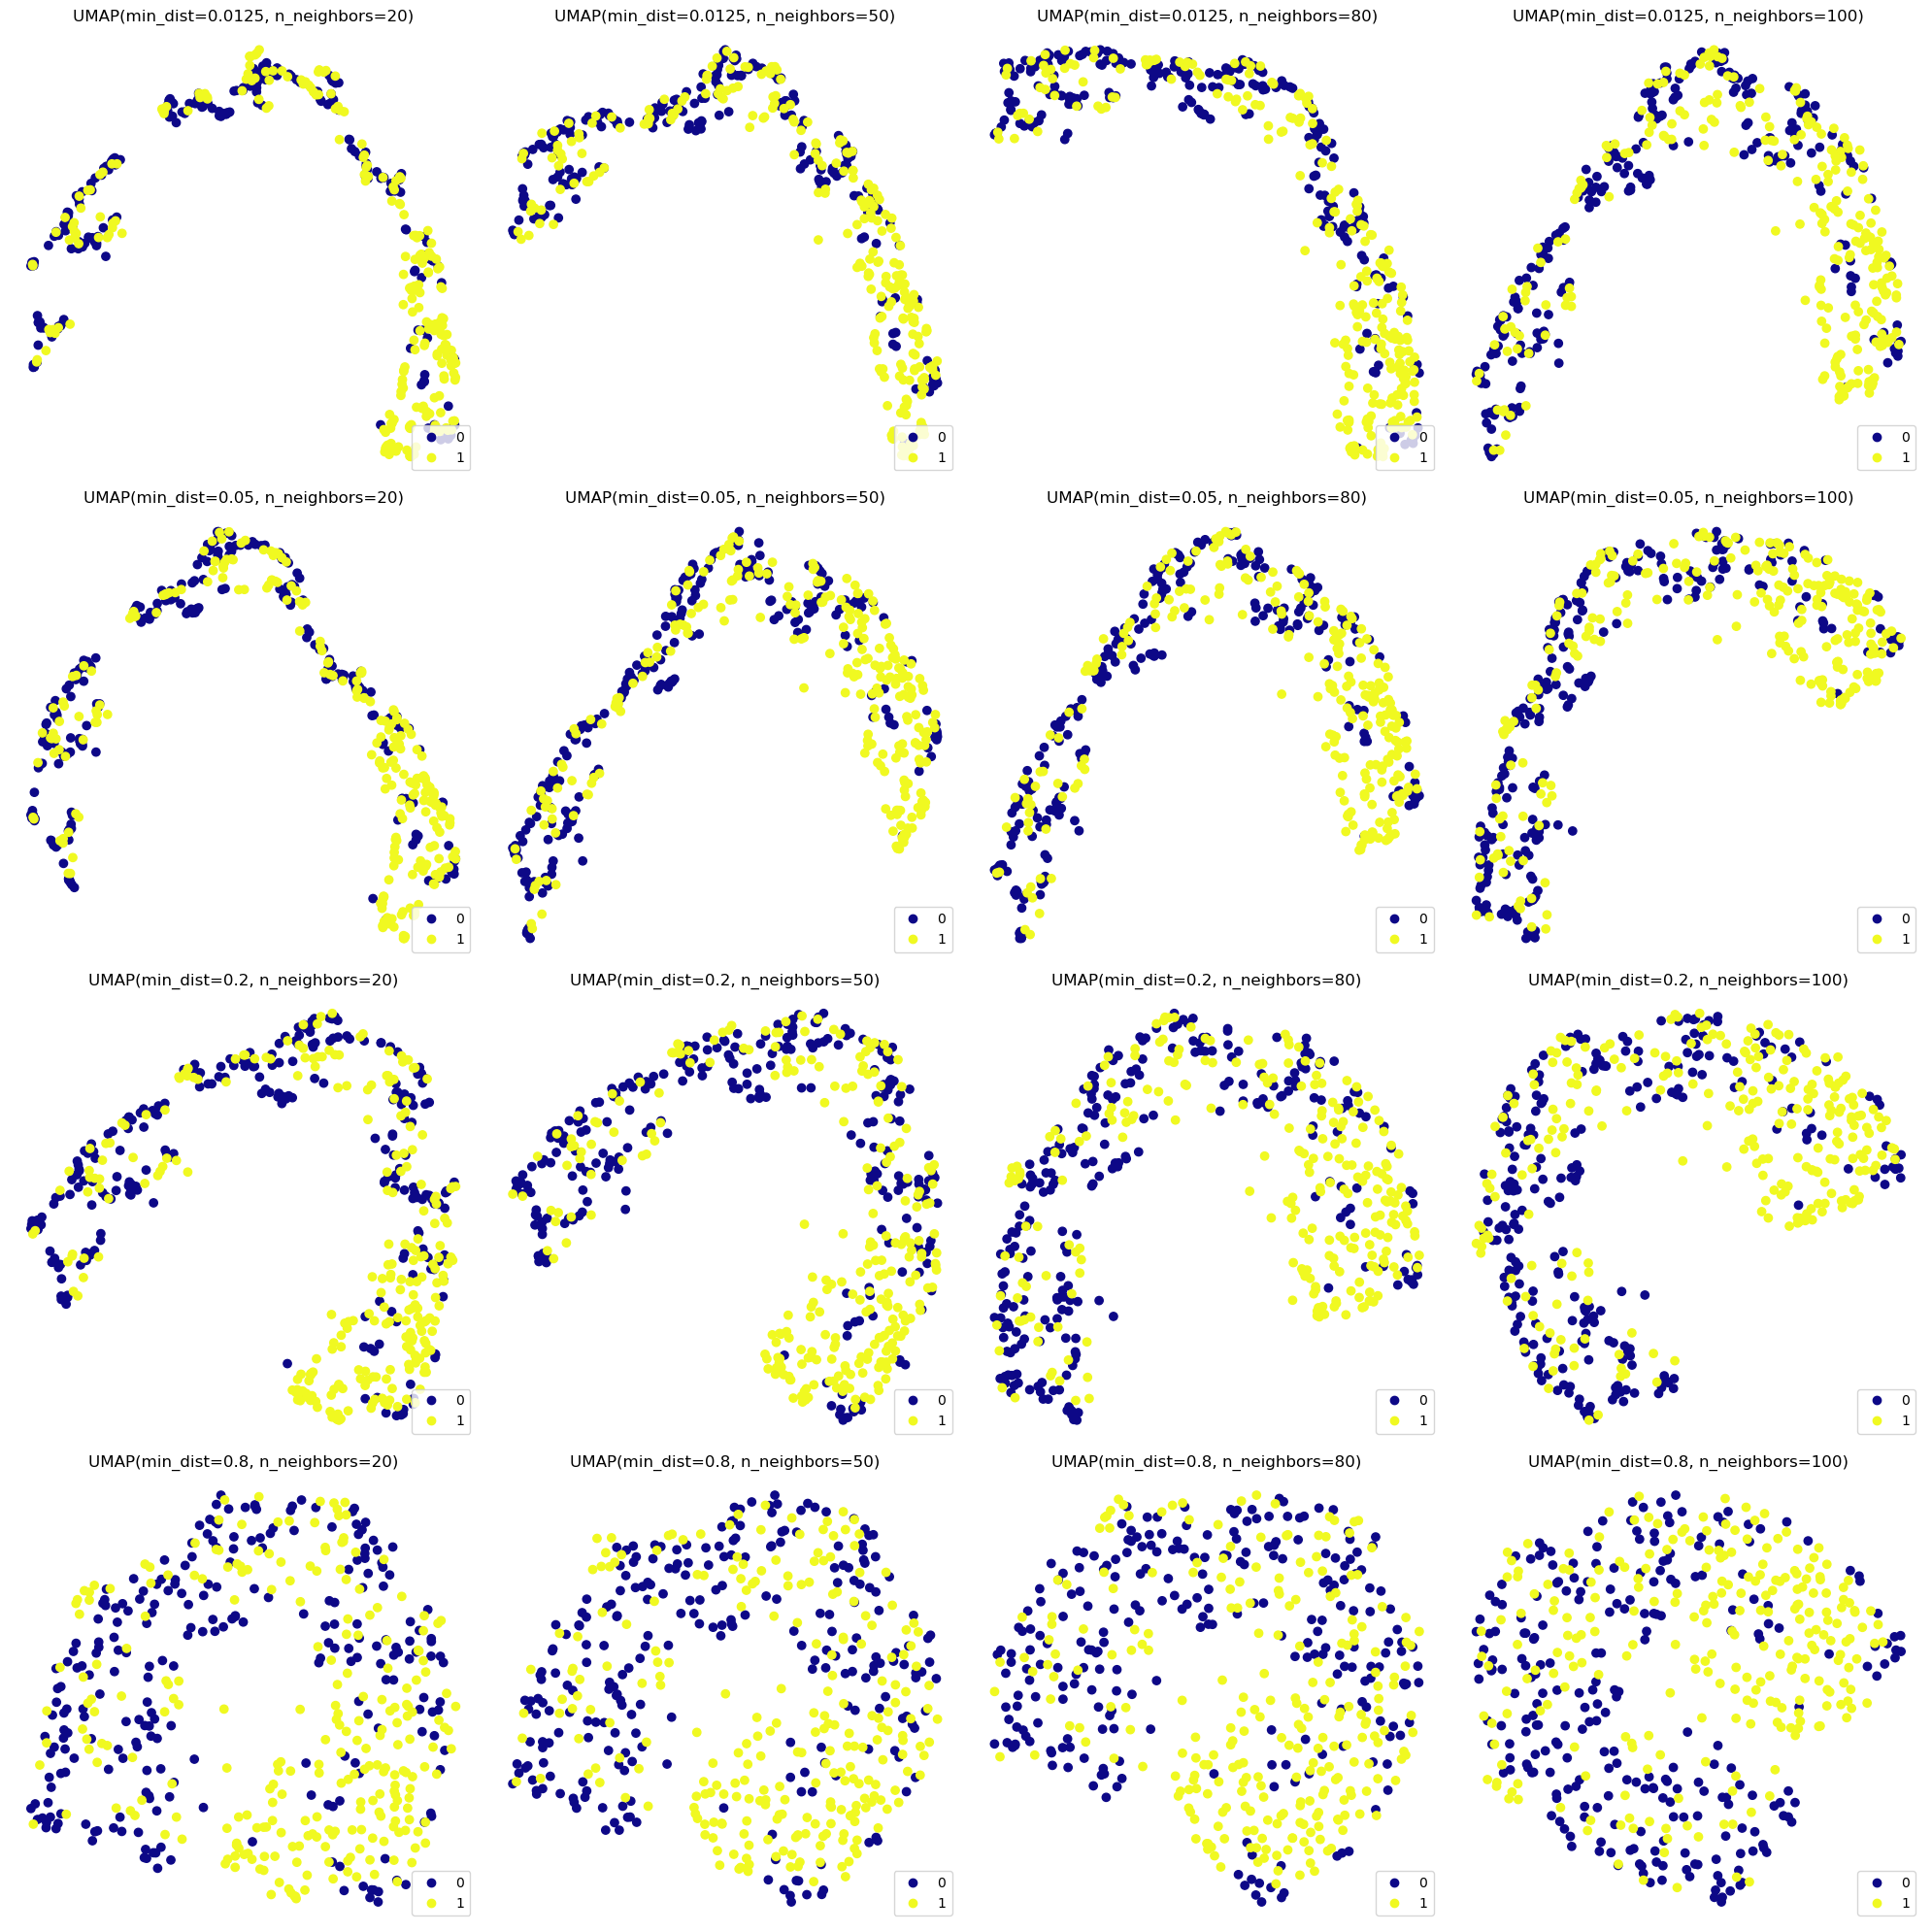

In [13]:
from tqdm import tqdm

min_dist_values = np.array([0.0125, 0.05, 0.2, 0.8])
n_neighbors_values = np.array([20, 50, 80, 100])

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, min_dist in enumerate(min_dist_values):
    for j, n_neighbors in enumerate(tqdm(n_neighbors_values)):
        # Perform UMAP on the features with current min_dist and n_neighbors
        umap_model = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors)
        embeddings = umap_model.fit_transform(ptbdb_pca)

        # Plot UMAP embeddings with labels
        ax = axes[i, j]
        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=ptbdb_labels_sub, cmap=plt.cm.plasma)
        ax.set_title(f'UMAP(min_dist={min_dist}, n_neighbors={n_neighbors})')
        ax.set_axis_off()
        ax.legend(*scatter.legend_elements(),loc='lower right')

plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


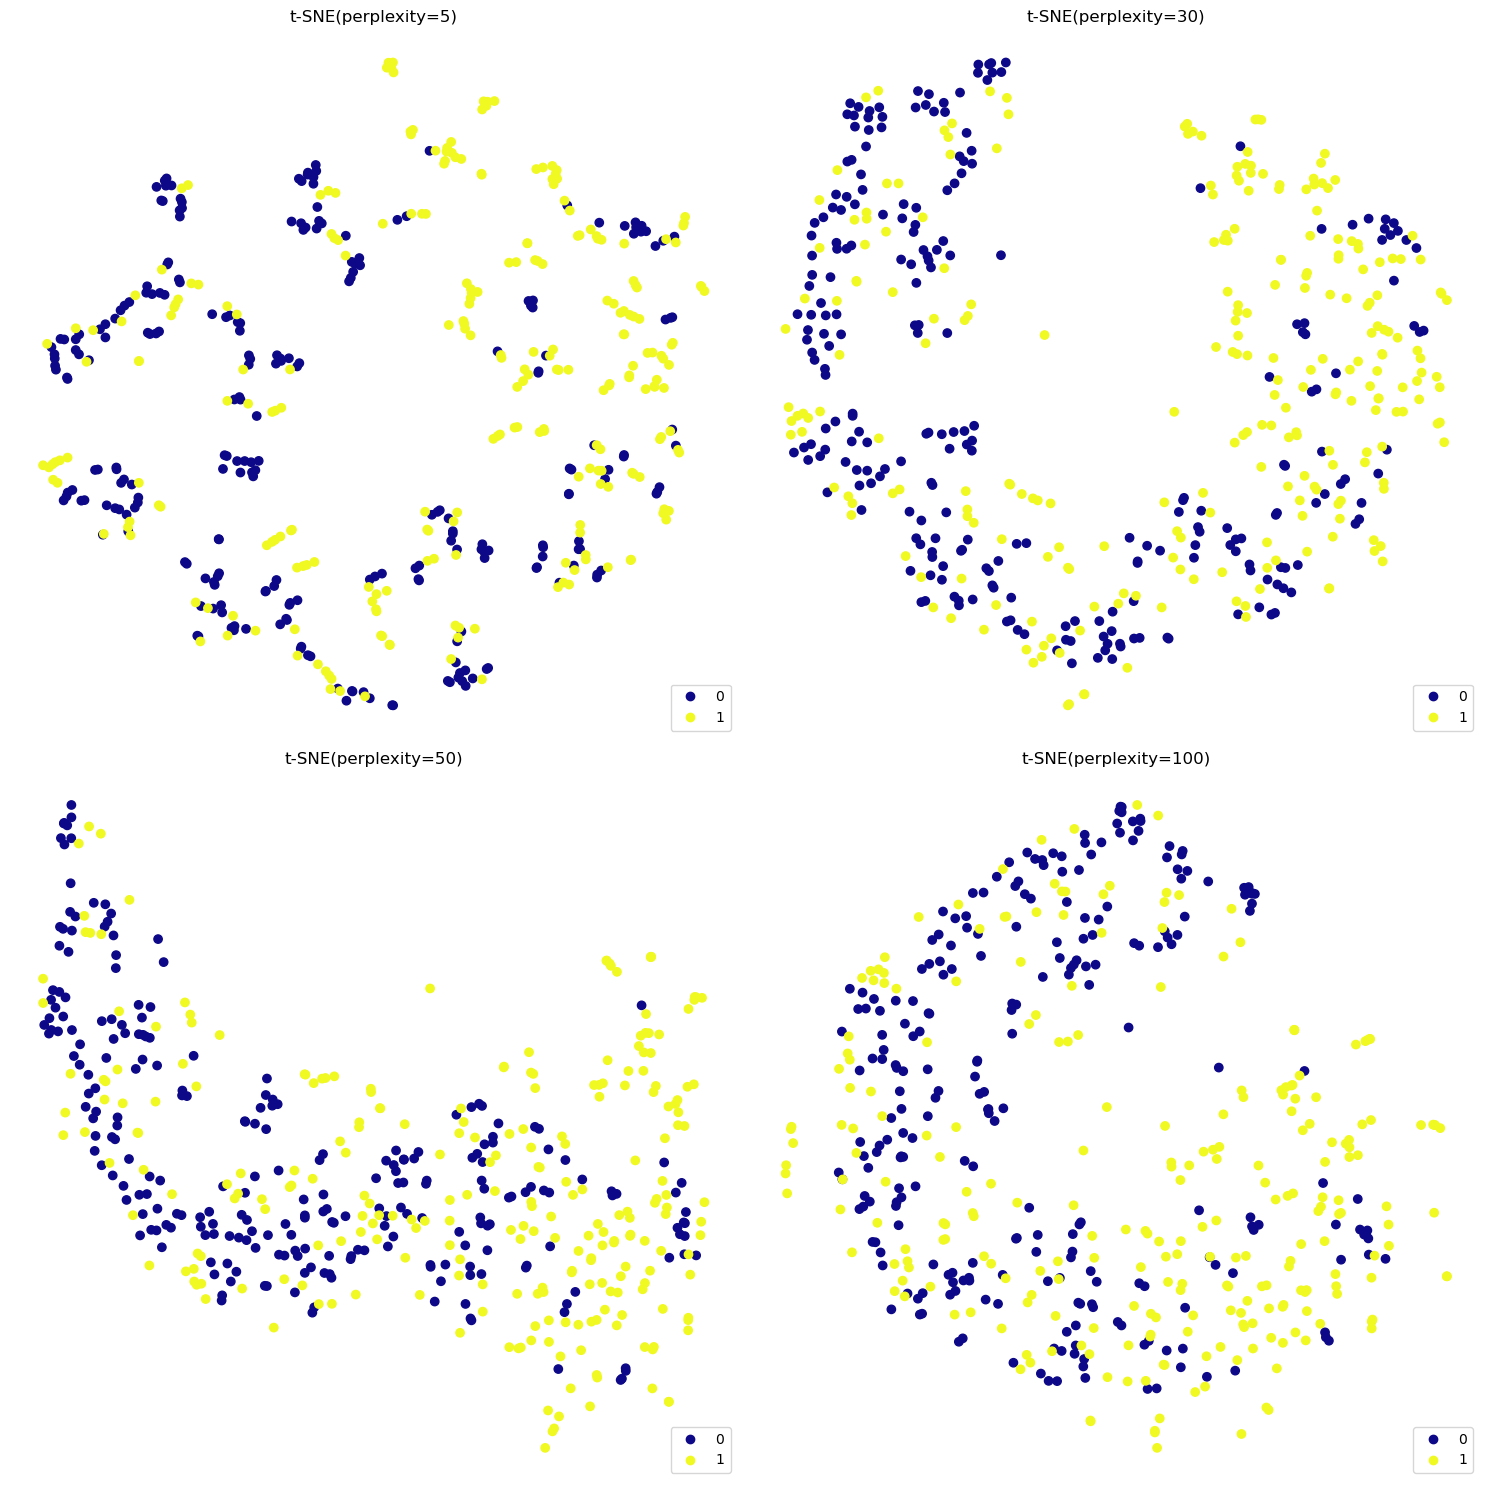

In [11]:
from tqdm import tqdm

perplexity_values = np.array([5, 30, 50, 100])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, perplexity in enumerate(tqdm(perplexity_values)):
    # Perform t-SNE on the features with fixed min_dist and varying perplexity
    tsne_model = TSNE(perplexity=perplexity)
    embeddings = tsne_model.fit_transform(ptbdb_pca)

    # Plot t-SNE embeddings with labels
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=ptbdb_labels_sub, cmap=plt.cm.plasma)
    ax.set_title(f't-SNE(perplexity={perplexity})')
    ax.set_axis_off()
    ax.legend(*scatter.legend_elements(), loc='lower right')

# Add a shared colorbar
plt.tight_layout()
plt.show()